In [ ]:
import sys
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath("../src"))

from preprocessor import LLMTIMEPreprocessor
from load_qwen import load_qwen_model
from final_model import LoRALinear, process_sequences, evaluate 
from compute_flops import compute_flops
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from accelerate import Accelerator
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from final_model import train_lora_model




Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Training:   0%|          | 0/6000 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training: 100%|██████████| 6000/6000 [3:43:00<00:00,  2.23s/it, loss=0.258]   


✅ Training complete. Evaluating...
📊 Validation loss: 0.2878
📈 Perplexity: 1.33


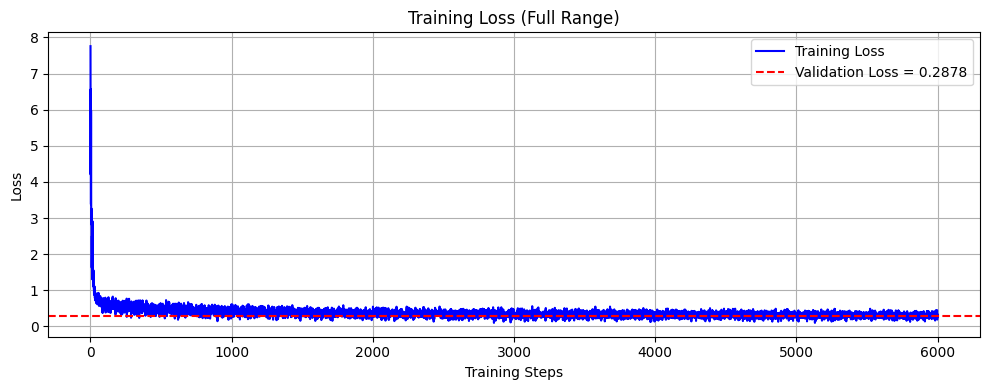

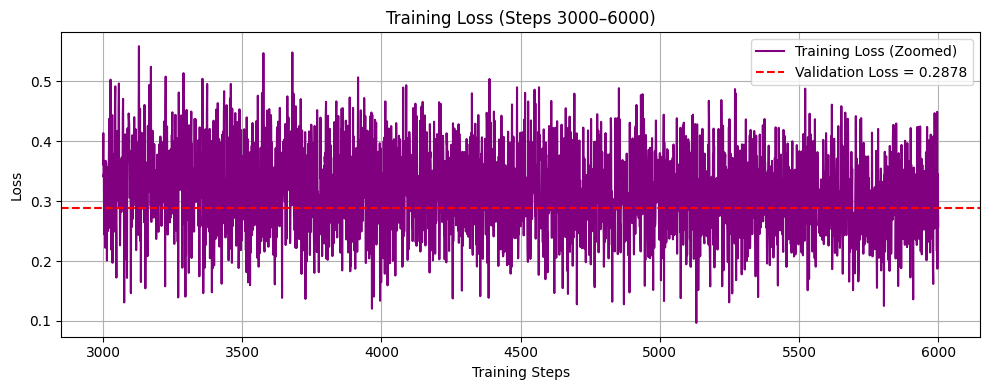

Training: 100%|██████████| 6000/6000 [3:44:32<00:00,  2.25s/it, loss=0.258]


In [ ]:
model, tokenizer, val_loader, val_loss, perplexity = train_lora_model(
    max_steps=6000,
    verbose=True
)

In [ ]:
compute_flops(
    data_path="../lotka_volterra_data.h5",
    input_fraction=1,
    lora_rank=8,
    batch_size=4,
    training_steps=6000,
    flop_budget=1e17,
    train_series_count=700,
    eval_series_count=200,
    context_length=768
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



 Context length used for FLOP estimation: 768 tokens

  Total Training FLOPs: 6.21e+16
  Total Evaluation FLOPs: 1.72e+14
  Total Combined FLOPs: 6.22e+16
  Percentage of FLOP budget used: 62.24668%


In [ ]:
torch.save(model.state_dict(), "trained_lora_model.pt")
print(" Model weights saved to trained_lora_model.pt")


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# === Load base model and tokenizer ===
model, tokenizer = load_qwen_model()

lora_rank = 8  
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

state_dict = torch.load("trained_lora_model.pt", map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()
print("Trained LoRA model loaded.")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Trained LoRA model loaded.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


📏 Sample 972 | Input tokens: 499, Generated tokens: 520


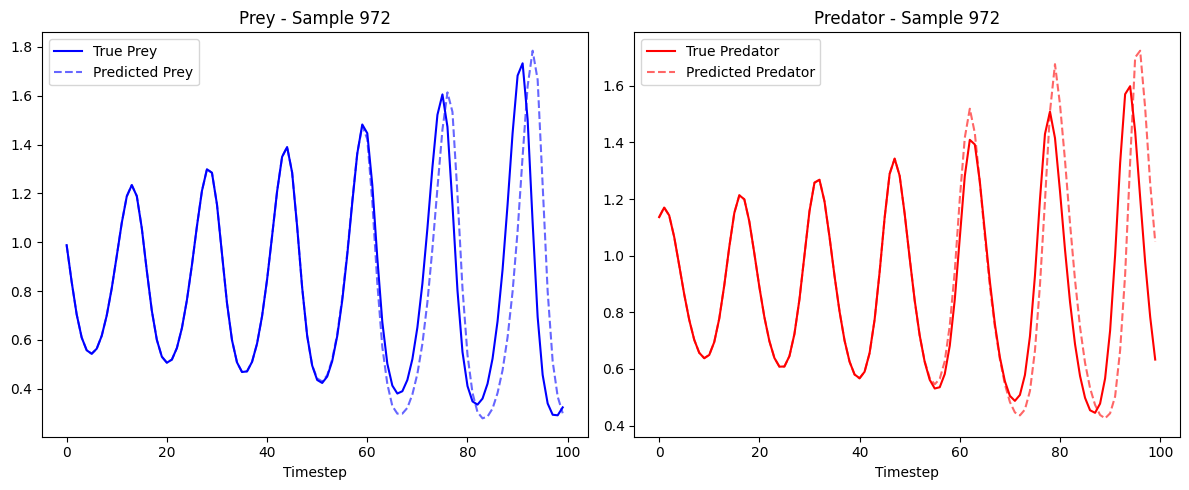

In [ ]:

preprocessor = LLMTIMEPreprocessor()
with h5py.File("../lotka_volterra_data.h5", "r") as f:
    data = f["trajectories"][:] 

def test_trained_model(data, sample_ids=[972], input_timesteps=70):
    predictions = {}
    for sample_id in sample_ids:
        prey = data[sample_id, :, 0]
        predator = data[sample_id, :, 1]

        input_text, tokenized_input, scale_factor = preprocessor.preprocess_sample(prey, predator, input_timesteps)
        tokens = tokenized_input.to(device)

        with torch.no_grad():
            generated = model.generate(tokens, max_new_tokens=300)

        semicolons = (generated[0] == tokenizer.convert_tokens_to_ids(';')).nonzero(as_tuple=True)[0]
        while len(semicolons) < 100 and len(generated[0]) < 2000:
            generated = model.generate(generated, max_new_tokens=20)
            semicolons = (generated[0] == tokenizer.convert_tokens_to_ids(';')).nonzero(as_tuple=True)[0]

        if len(semicolons) >= 100:
            tokens_1d = generated[0][:semicolons[99] + 1]
        else:
            tokens_1d = generated[0]

        decoded = tokenizer.decode(tokens_1d, skip_special_tokens=True)
        decoded_pairs = [list(map(float, pair.split(','))) for pair in decoded.split(';') if ',' in pair]
        decoded_prey, decoded_predator = zip(*decoded_pairs) if decoded_pairs else ([], [])

        predictions[sample_id] = {
            "prey": np.array(decoded_prey) * scale_factor,
            "predator": np.array(decoded_predator) * scale_factor
        }

        print(f" Sample {sample_id} | Input tokens: {tokenized_input.shape[1]}, Generated tokens: {generated.shape[1] - tokens.shape[1]}")

    return predictions

# === Predict ===
predictions = test_trained_model(data, sample_ids=[972], input_timesteps=50)

# === Plotting function ===
def plot_predictions(predictions, original_series, sample_id):
    pred_prey = predictions[sample_id]["prey"]
    pred_predator = predictions[sample_id]["predator"]
    true_prey = original_series[:, 0]
    true_predator = original_series[:, 1]
    timesteps = np.arange(len(true_prey))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(timesteps, true_prey, label='True Prey', color='blue')
    plt.plot(timesteps[:len(pred_prey)], pred_prey, '--', label='Predicted Prey', color='blue', alpha=0.6)
    plt.title(f"Prey - Sample {sample_id}")
    plt.xlabel("Timestep")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, true_predator, label='True Predator', color='red')
    plt.plot(timesteps[:len(pred_predator)], pred_predator, '--', label='Predicted Predator', color='red', alpha=0.6)
    plt.title(f"Predator - Sample {sample_id}")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"sample{sample_id}_trained.png", dpi=300)
    plt.show()

# === Run plotting and metrics ===
original_series = data[972]
plot_predictions(predictions, original_series, sample_id=972)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_metrics(predictions, original_series, sample_id):
    pred_prey = predictions[sample_id]["prey"]
    pred_predator = predictions[sample_id]["predator"]
    true_prey = original_series[:, 0]
    true_predator = original_series[:, 1]

    # Ensure predictions and ground truth align in length
    min_len_prey = min(len(pred_prey), len(true_prey))
    min_len_predator = min(len(pred_predator), len(true_predator))

    prey_metrics = {
        "MSE": mean_squared_error(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
        "MAE": mean_absolute_error(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
        "R²":  r2_score(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
    }

    predator_metrics = {
        "MSE": mean_squared_error(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
        "MAE": mean_absolute_error(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
        "R²":  r2_score(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
    }

    print(f"\nEvaluation Metrics for Sample ID {sample_id}")
    print("Prey:")
    for k, v in prey_metrics.items():
        print(f"  {k}: {v:.4f}")
    print("Predator:")
    for k, v in predator_metrics.items():
        print(f"  {k}: {v:.4f}")

    return {"prey": prey_metrics, "predator": predator_metrics}

# === Run the metrics ===
metrics = evaluate_metrics(predictions, original_series, sample_id=972)



📊 Evaluation Metrics for Sample ID 972
Prey:
  MSE: 0.0170
  MAE: 0.0671
  R²: 0.8772
Predator:
  MSE: 0.0125
  MAE: 0.0608
  R²: 0.8600


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


📏 Sample 990 | Input tokens: 504, Generated tokens: 520
📏 Sample 991 | Input tokens: 504, Generated tokens: 520
📏 Sample 992 | Input tokens: 504, Generated tokens: 520
📏 Sample 993 | Input tokens: 505, Generated tokens: 520
📏 Sample 994 | Input tokens: 505, Generated tokens: 520
📏 Sample 995 | Input tokens: 504, Generated tokens: 520
📏 Sample 996 | Input tokens: 504, Generated tokens: 520
📏 Sample 997 | Input tokens: 499, Generated tokens: 520
📏 Sample 998 | Input tokens: 504, Generated tokens: 520
📏 Sample 999 | Input tokens: 504, Generated tokens: 513


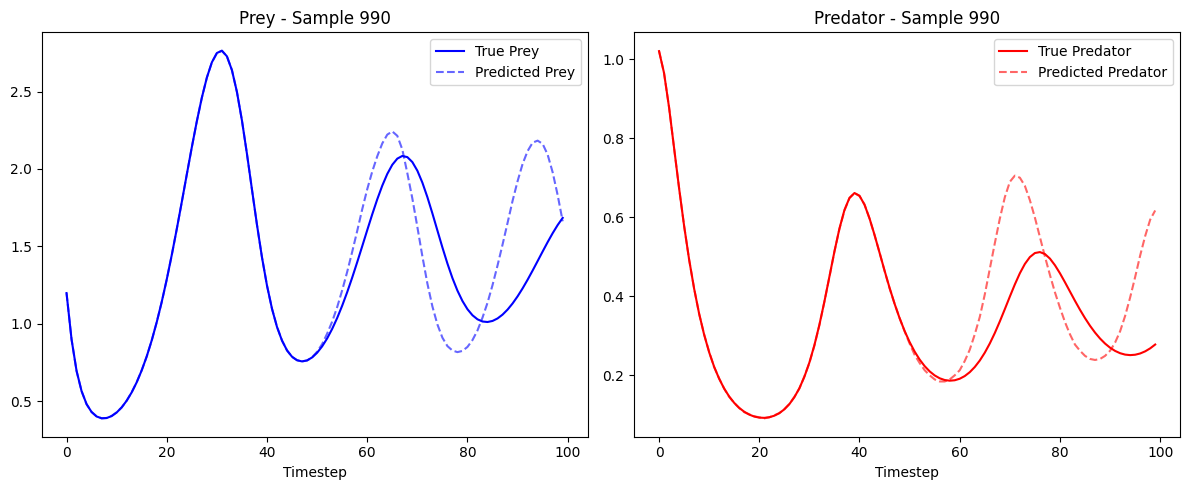


📊 Evaluation Metrics for Sample ID 990
Prey:
  MSE: 0.0857
  MAE: 0.1677
  R²: 0.7749
Predator:
  MSE: 0.0109
  MAE: 0.0550
  R²: 0.7034


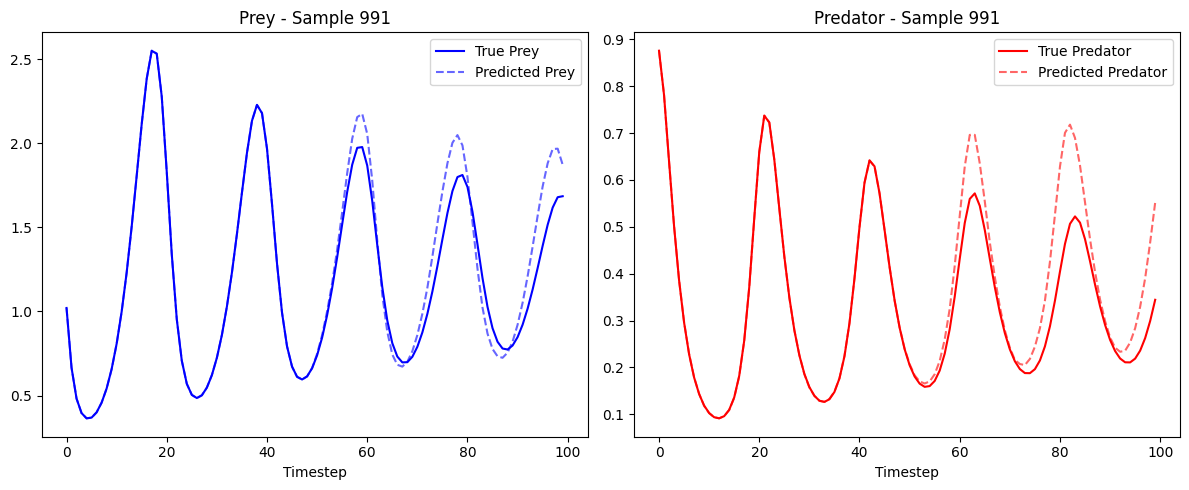


📊 Evaluation Metrics for Sample ID 991
Prey:
  MSE: 0.0151
  MAE: 0.0699
  R²: 0.9509
Predator:
  MSE: 0.0046
  MAE: 0.0342
  R²: 0.8555


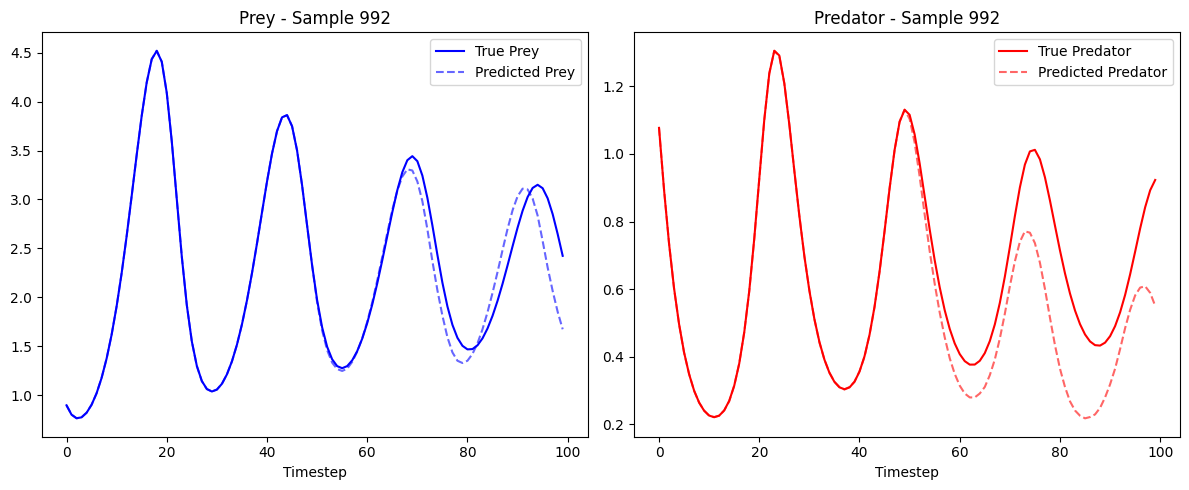


📊 Evaluation Metrics for Sample ID 992
Prey:
  MSE: 0.0436
  MAE: 0.1026
  R²: 0.9540
Predator:
  MSE: 0.0194
  MAE: 0.0850
  R²: 0.7581


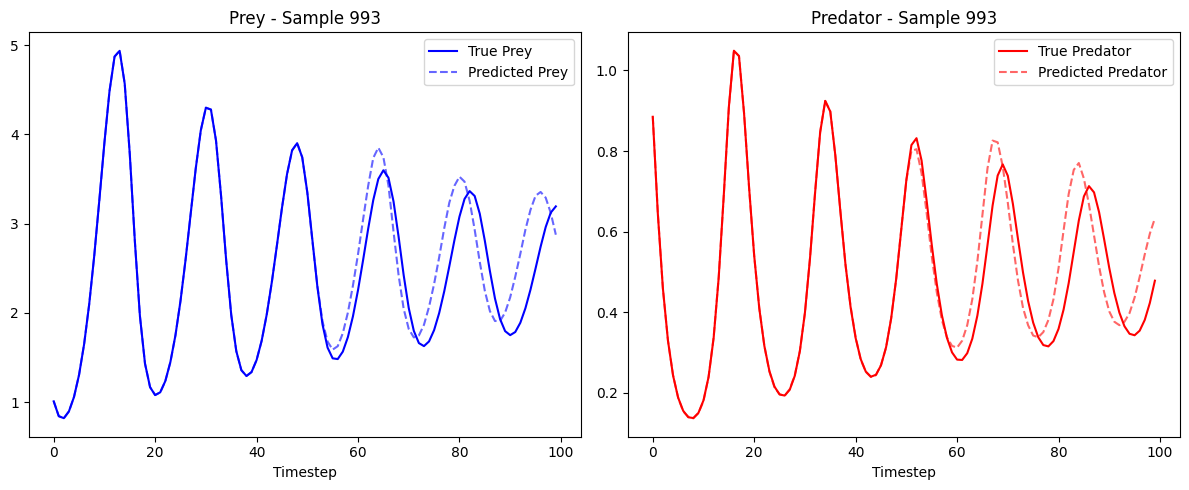


📊 Evaluation Metrics for Sample ID 993
Prey:
  MSE: 0.0931
  MAE: 0.1784
  R²: 0.9047
Predator:
  MSE: 0.0054
  MAE: 0.0425
  R²: 0.8897


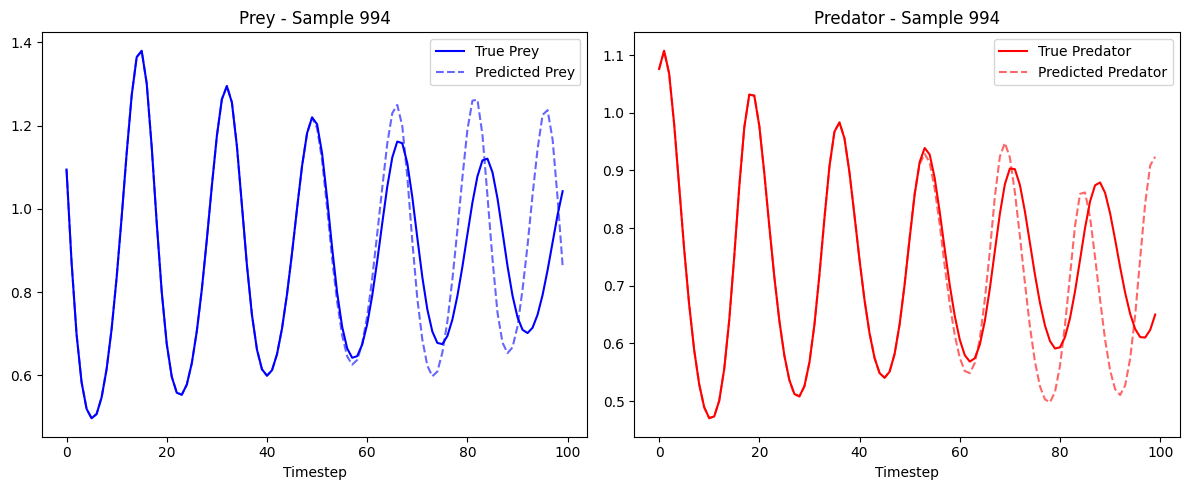


📊 Evaluation Metrics for Sample ID 994
Prey:
  MSE: 0.0138
  MAE: 0.0624
  R²: 0.7243
Predator:
  MSE: 0.0077
  MAE: 0.0464
  R²: 0.6902


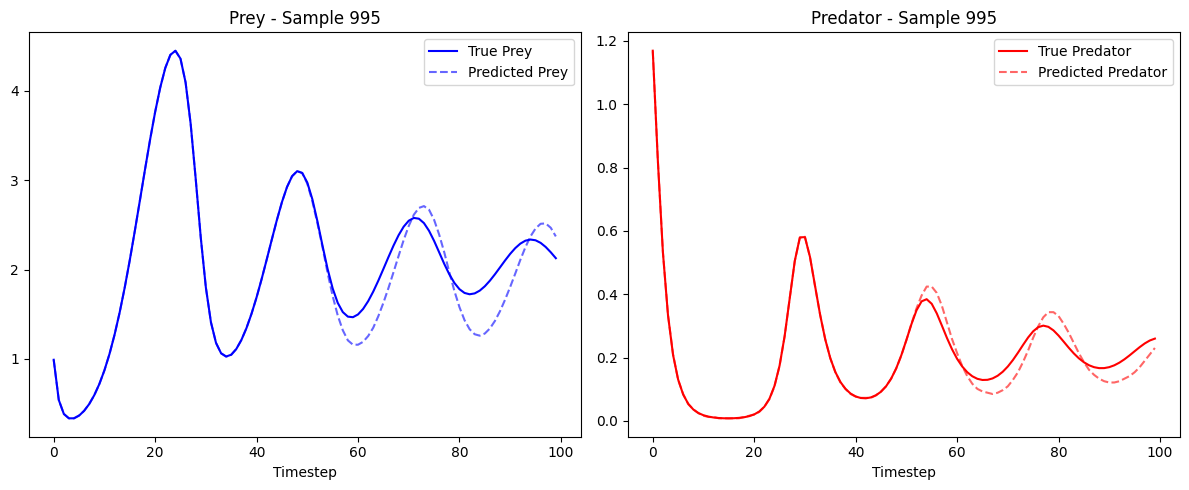


📊 Evaluation Metrics for Sample ID 995
Prey:
  MSE: 0.0417
  MAE: 0.1224
  R²: 0.9510
Predator:
  MSE: 0.0010
  MAE: 0.0201
  R²: 0.9674


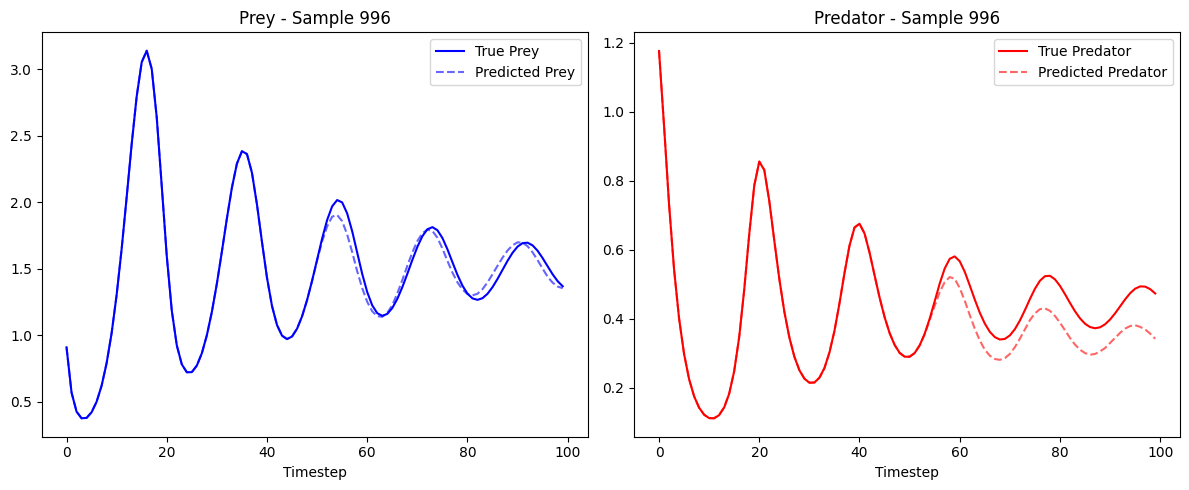


📊 Evaluation Metrics for Sample ID 996
Prey:
  MSE: 0.0025
  MAE: 0.0299
  R²: 0.9920
Predator:
  MSE: 0.0031
  MAE: 0.0358
  R²: 0.9050


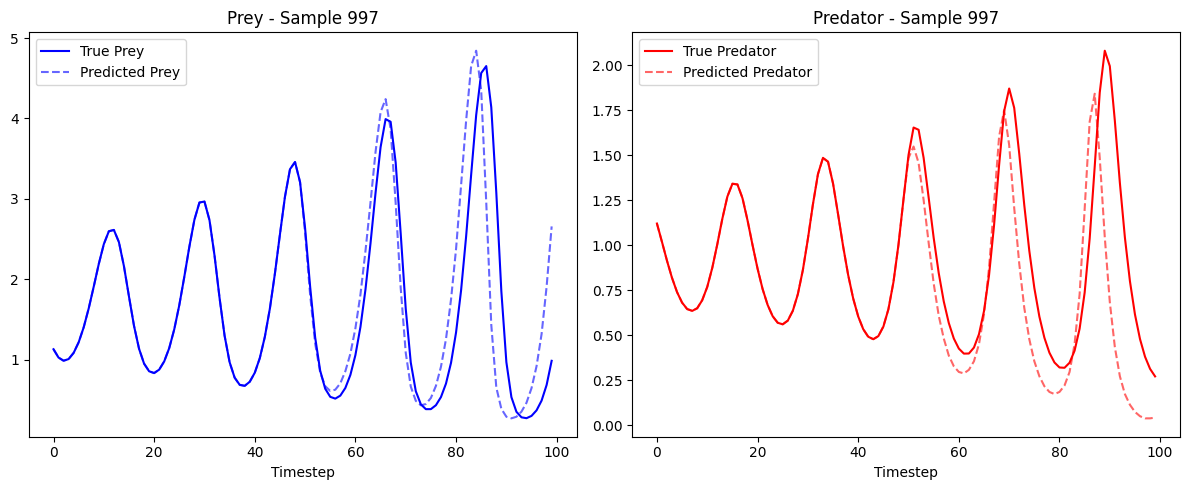


📊 Evaluation Metrics for Sample ID 997
Prey:
  MSE: 0.3527
  MAE: 0.2881
  R²: 0.7110
Predator:
  MSE: 0.1070
  MAE: 0.1705
  R²: 0.4364


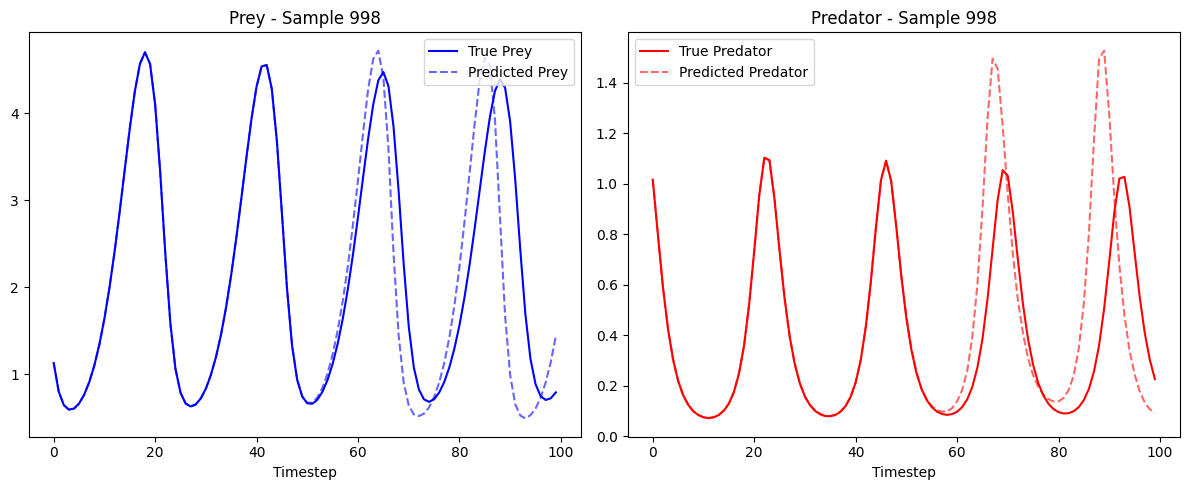


📊 Evaluation Metrics for Sample ID 998
Prey:
  MSE: 0.4794
  MAE: 0.3415
  R²: 0.7470
Predator:
  MSE: 0.0726
  MAE: 0.1245
  R²: 0.3372


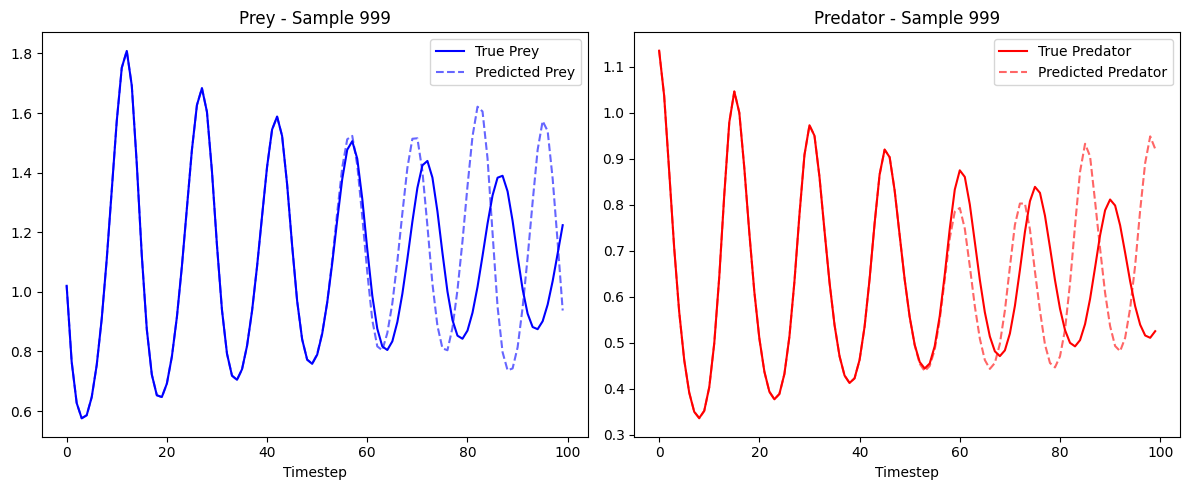


📊 Evaluation Metrics for Sample ID 999
Prey:
  MSE: 0.0500
  MAE: 0.1200
  R²: 0.4451
Predator:
  MSE: 0.0183
  MAE: 0.0735
  R²: 0.4616

📈 Average Metrics Across Samples 990–999

🔬 Prey:
  Avg MSE: 0.1178
  Avg MAE: 0.1483
  Avg R²: 0.8155

🔬 Predator:
  Avg MSE: 0.0250
  Avg MAE: 0.0687
  Avg R²: 0.7004


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Preprocessor and data ===
preprocessor = LLMTIMEPreprocessor()
with h5py.File("../lotka_volterra_data.h5", "r") as f:
    data = f["trajectories"][:]  # (N, 100, 2)

# === Prediction function for trained model ===
def test_trained_model(data, sample_ids=[972], input_timesteps=70):
    predictions = {}
    for sample_id in sample_ids:
        prey = data[sample_id, :, 0]
        predator = data[sample_id, :, 1]

        input_text, tokenized_input, scale_factor = preprocessor.preprocess_sample(prey, predator, input_timesteps)
        tokens = tokenized_input.to(device)

        with torch.no_grad():
            generated = model.generate(tokens, max_new_tokens=300)

        semicolons = (generated[0] == tokenizer.convert_tokens_to_ids(';')).nonzero(as_tuple=True)[0]
        while len(semicolons) < 100 and len(generated[0]) < 2000:
            generated = model.generate(generated, max_new_tokens=20)
            semicolons = (generated[0] == tokenizer.convert_tokens_to_ids(';')).nonzero(as_tuple=True)[0]

        if len(semicolons) >= 100:
            tokens_1d = generated[0][:semicolons[99] + 1]
        else:
            tokens_1d = generated[0]

        decoded = tokenizer.decode(tokens_1d, skip_special_tokens=True)
        decoded_pairs = [list(map(float, pair.split(','))) for pair in decoded.split(';') if ',' in pair]
        decoded_prey, decoded_predator = zip(*decoded_pairs) if decoded_pairs else ([], [])

        predictions[sample_id] = {
            "prey": np.array(decoded_prey) * scale_factor,
            "predator": np.array(decoded_predator) * scale_factor
        }

        print(f" Sample {sample_id} | Input tokens: {tokenized_input.shape[1]}, Generated tokens: {generated.shape[1] - tokens.shape[1]}")

    return predictions

def plot_predictions(predictions, original_series, sample_id):
    pred_prey = predictions[sample_id]["prey"]
    pred_predator = predictions[sample_id]["predator"]
    true_prey = original_series[:, 0]
    true_predator = original_series[:, 1]
    timesteps = np.arange(len(true_prey))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(timesteps, true_prey, label='True Prey', color='blue')
    plt.plot(timesteps[:len(pred_prey)], pred_prey, '--', label='Predicted Prey', color='blue', alpha=0.6)
    plt.title(f"Prey - Sample {sample_id}")
    plt.xlabel("Timestep")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, true_predator, label='True Predator', color='red')
    plt.plot(timesteps[:len(pred_predator)], pred_predator, '--', label='Predicted Predator', color='red', alpha=0.6)
    plt.title(f"Predator - Sample {sample_id}")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_metrics(predictions, original_series, sample_id):
    pred_prey = predictions[sample_id]["prey"]
    pred_predator = predictions[sample_id]["predator"]
    true_prey = original_series[:, 0]
    true_predator = original_series[:, 1]

    # Ensure predictions and ground truth align in length
    min_len_prey = min(len(pred_prey), len(true_prey))
    min_len_predator = min(len(pred_predator), len(true_predator))

    prey_metrics = {
        "MSE": mean_squared_error(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
        "MAE": mean_absolute_error(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
        "R²":  r2_score(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
    }

    predator_metrics = {
        "MSE": mean_squared_error(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
        "MAE": mean_absolute_error(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
        "R²":  r2_score(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
    }

    print(f"\n Evaluation Metrics for Sample ID {sample_id}")
    print("Prey:")
    for k, v in prey_metrics.items():
        print(f"  {k}: {v:.4f}")
    print("Predator:")
    for k, v in predator_metrics.items():
        print(f"  {k}: {v:.4f}")

    return {"prey": prey_metrics, "predator": predator_metrics}

# === Predict for sample IDs 990–999 ===
sample_ids = list(range(990, 1000))
predictions = test_trained_model(data, sample_ids=sample_ids, input_timesteps=50)

# === Track all metrics ===
all_metrics = {
    "prey": {"MSE": [], "MAE": [], "R²": []},
    "predator": {"MSE": [], "MAE": [], "R²": []}
}

# === Evaluate and plot each ===
for sample_id in sample_ids:
    original_series = data[sample_id]
    plot_predictions(predictions, original_series, sample_id)
    metrics = evaluate_metrics(predictions, original_series, sample_id)

    for target in ["prey", "predator"]:
        for metric in ["MSE", "MAE", "R²"]:
            all_metrics[target][metric].append(metrics[target][metric])

# === Compute and print averages ===
print("\n Average Metrics Across Samples 990–999")
for target in ["prey", "predator"]:
    print(f"\n {target.capitalize()}:")
    for metric in ["MSE", "MAE", "R²"]:
        avg = np.mean(all_metrics[target][metric])
        print(f"  Avg {metric}: {avg:.4f}")
